# fMRI Demo (SPM version)

## Introduction

This is an example of RSA on a fMRI dataset that was analyzed with SPM. The data is described in the following papers:
- Diedrichsen, J., Wiestler, T., & Krakauer, J. W. W. (2013). Two distinct ipsilateral cortical representations for individuated finger movements. Cerebral Cortex , 23(6), 1362–1377.
- Ejaz, N., Hamada, M., & Diedrichsen, J. (2015). Hand use predicts the structure of representations in sensorimotor cortex. Nature Neuroscience, 18(7), 1034–1040.

In the paradigm, participants made individual finger presses with one of the 5 fingers of the left or right hand. The data was preprocessed and analyzed with SPM. We are providing and analyzing only one single subject's data here https://www.dropbox.com/scl/fo/94njk5dq80niybi57cfgj/AEfF_YbXg8G50l0xgXPNzEY?rlkey=9v7x4l03xpfjrn1b6tqetw9rf&dl=0. 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from rsatoolbox.data import Dataset
from rsatoolbox.io.spm import SpmGlm
import rsatoolbox as rsa
import matplotlib.pyplot as plt

## Define the SPM GLM object 
We need to define the directory where the example data is located. 

In [2]:
data_dir = os.path.expanduser('~/data/rsatoolbox/diedrichsen')

In [3]:
## Initialize the GLM object from the SPM.mat file
spm=SpmGlm(data_dir + '/glm_firstlevel')
spm.get_info_from_spm_mat()

## RDM from univariate pre-whitened betas

In [4]:
# Get the betas and residual mean-square image for left M1
[beta,ResMS,info]=spm.get_betas(data_dir + '/anat/M1_L.nii')
print(f'Shape of Betas: {beta.shape[0]}x{beta.shape[1]}')

Shape of Betas: 80x362


In [5]:
# Extract digit and hand number from regressor names
info = pd.DataFrame(info)
info['hand']=[int(r[4]) for r in info['reg_name']]
info['digit']=[int(r[11]) for r in info['reg_name']]
info['condition']=(info['hand']-1)*5+info['digit']
info

,reg_name,run_number,hand,digit,condition
0,hand1_digit1*bf(1),1,1,1,1
1,hand1_digit2*bf(1),1,1,2,2
2,hand1_digit3*bf(1),1,1,3,3
3,hand1_digit4*bf(1),1,1,4,4
4,hand1_digit5*bf(1),1,1,5,5
...,...,...,...,...,...
75,hand2_digit1*bf(1),8,2,1,6
76,hand2_digit2*bf(1),8,2,2,7
77,hand2_digit3*bf(1),8,2,3,8
78,hand2_digit4*bf(1),8,2,4,9


In [6]:
# Get a RSA dataset from the univariate prewhitened betas
data = Dataset(
            measurements=beta/np.sqrt(ResMS),
            obs_descriptors=dict(info)
)

In [7]:
# Calculate the RDM on all ten conditions. 

RDM_uni = rsa.rdm.calc_rdm(
    data,
    method='crossnobis',
    descriptor='condition',
    cv_descriptor='run_number')

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


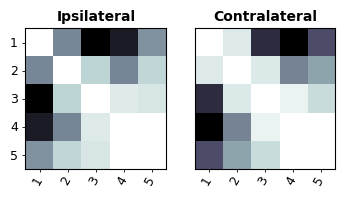

In [8]:
# seperate the part for the left and right hand
left_hand_rdm = RDM_uni.subset_pattern('hand', 1)
right_hand_rdm = RDM_uni.subset_pattern('hand', 2)

# Plot the two together (note the different color scales)
RDMs=rsa.rdm.concat([left_hand_rdm,right_hand_rdm])
RDMs.rdm_descriptors['name']=['Ipsilateral','Contralateral']
rsa.vis.show_rdm(RDMs,pattern_descriptor='digit',rdm_descriptor='name')
plt.show()

## RDM from multivariate pattern analysis
For multivariate pre-whitening, we need to go back to the original time series data to obtain the residuals from the first-level analysis. These are not saved by default in SPM, so we need to recompute them.
While it would be possible to save the residuals in the first-level analysis, this would require a lot of disk space. 
Instead, we can use the original data and the design matrix to compute the residuals and betas on the fly.

In [9]:
# Get the betas and residual mean-square image for left M1
[residuals,beta,info]=spm.get_residuals(data_dir + '/anat/M1_L.nii')
print(f'Shape of Betas: {beta.shape[0]}x{beta.shape[1]}')

Shape of Betas: 80x362


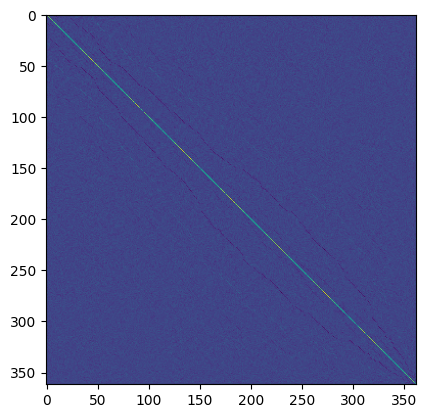

In [10]:
# Compute precision matrix (inverse of covariance matrix) from residuals
Prec = rsa.data.noise.prec_from_residuals(
            residuals,
            dof=spm.eff_df,
            method='shrinkage_diag'
        )
plt.imshow(Prec)

In [11]:
# Calculate the RDM on all ten conditions. 
RDM_multi = rsa.rdm.calc_rdm(
    data,
    method='crossnobis',
    noise = Prec,
    descriptor='condition',
    cv_descriptor='run_number')


/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


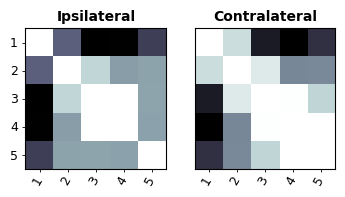

In [12]:
# seperate the part for the left and right hand
left_hand_rdm = RDM_multi.subset_pattern('hand', 1)
right_hand_rdm = RDM_multi.subset_pattern('hand', 2)

# Plot the two together (note the different color scales)
RDMs=rsa.rdm.concat([left_hand_rdm,right_hand_rdm])
RDMs.rdm_descriptors['name']=['Ipsilateral','Contralateral']
rsa.vis.show_rdm(RDMs,pattern_descriptor='digit',rdm_descriptor='name')
plt.show()